# 1 Convolution

In [39]:
import torch
from torch import nn
from d2l import torch as d2l


def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)


class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias
    

    
X = torch.ones((6, 8))
X[:, 2:6] = 0
X
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y

conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 6.373
epoch 4, loss 1.107
epoch 6, loss 0.201
epoch 8, loss 0.040
epoch 10, loss 0.009


In [40]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

# Define the directional vector v
v = torch.tensor([1.0, 2.0])

# Derive an edge-detection kernel orthogonal to v
K = torch.tensor([[0.0, -1.0], [1.0, 0.0]])

# Test the edge-detection kernel on a sample input X
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
output = corr2d(X, K)
print("Output after applying edge-detection kernel:")
print(output)


Output after applying edge-detection kernel:
tensor([[2., 2.],
        [2., 2.]])


In [41]:
# Define the second derivative operator kernel
K = torch.tensor([[1.0, -2.0, 1.0]])

# Test the second derivative operator kernel on a sample input X
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
output = corr2d(X, K)
print("Output after applying second derivative operator kernel:")
print(output)


Output after applying second derivative operator kernel:
tensor([[0.],
        [0.],
        [0.]])


### BLUR

In [43]:
import torch
from torch import nn
from d2l import torch as d2l

def gaussian_blur_kernel(size, sigma=1):
    """Generate a 2D Gaussian blur kernel."""
    kernel_1d = torch.tensor([torch.exp(-(size // 2) ** 2 / (2 * sigma ** 2))])
    kernel_2d = torch.outer(kernel_1d, kernel_1d)
    kernel_2d /= kernel_2d.sum()  # Normalize the kernel
    return kernel_2d.float()  # Convert to float

# Generate a Gaussian blur kernel
kernel_size = torch.tensor([1.0])  
blur_kernel = gaussian_blur_kernel(kernel_size)

# Print the blur kernel
print("Blur Kernel:")
print(blur_kernel)

# Apply the blur kernel to an image
X = torch.ones((6, 8))  # Sample image
X[:, 2:6] = 0  # Add a vertical stripe for visualization
blurred_image = corr2d(X, blur_kernel)

# Print the blurred image
print("\nBlurred Image:")
print(blurred_image)


Blur Kernel:
tensor([[1.]])

Blurred Image:
tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])


##### In order to obtain a derivative of order d, we require one more points than the derivate order. Thus for a third order derivative we require at lest four points on the kernel, or a minimum kernel size of 4.

# 2

In [30]:
import torch
from torch import nn

# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape


conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

c:\Users\aidan\PythonEnvironment\AI\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 2])

#### It matches the output from the equations.

# 3

In [36]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

K = torch.stack((K, K + 1, K + 2), 0)
K.shape

corr2d_multi_in_out(X, K)


def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    noComputations = c_i*c_o*h*w
    memory = c_i*h*w+c_o*c_i+c_o*h*w
    print(noComputations)
    print(memory)
    return Y.reshape((c_o, h, w))
   


X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6




54
51


In the forward propogation the computational cost comes from the torch.matmul function, doing matrix multiplication between X and K as well as the reshaping of the matrix at the end. In this case, there are 54 multiplications and 54 additions.

The memory footprint consists of X of shape(c_i,h,w), K of shape(c_o,c_i), and Y of shape(c_o,h,w). In this case the memory footprint has size of 51.

The memory footprint of backward computation consists of the gradient from tensors X and K, as well as the shape of the intermediate layers. Just using the code from 7.4 does not provide a specific nn implementation, so a specific memory footprint size can not be found.

With that in mind the total computational cost of backpropogation can not be specifically determined with the current structure. During backpropogation, three sets of gradients need to be calculate, the gradients with respect to the outputs, the weights, and the inputs from the previous pass. The shape of the gradients changes based on the type or structure of nueral network used. Calculating the number of computations needed to calculate each of those gradients will sum to the total computational cost.


# 4 Pooling

In [39]:
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)


tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [40]:
X = torch.cat((X, X + 1), 1)
X

pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

In [45]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

# Average Pooling
pool_size = (2, 2)
pooling_mode = 'avg'
pool2d_avg = pool2d(X, pool_size, mode=pooling_mode)

# Using PyTorch's MaxPool2d for validation
import torch.nn as nn
pool2d_avg_torch = nn.AvgPool2d(pool_size)(X)
print(f'Torch Average Pooling Result:\n{pool2d_avg_torch}\n')

# Max Pooling for comparison
pool2d_max_torch = nn.MaxPool2d(pool_size)(X)
print(f'Torch Max Pooling Result:\n{pool2d_max_torch}')

Torch Average Pooling Result:
tensor([[[[ 2.5000,  4.5000],
          [10.5000, 12.5000]]]])

Torch Max Pooling Result:
tensor([[[[ 5.,  7.],
          [13., 15.]]]])


In [56]:
### Determine relu equivalent for max

a = [12,-2,1,4,0]
b = [2,1,-3,9,-2]

def relu(x):
    return max(x,0)

def check_relu_equation(a, b):
    for x_a, x_b in zip(a, b):
            if max(x_a, x_b) != relu(x_a - x_b) + x_b:
                return False
                break
            else:
                 return True
            
check_relu_equation(a,b)
    



True

In [28]:
import torch
import torch.nn.functional as F

def max_pooling_conv(input_tensor, pool_size):
    batch_size, channels, height, width = input_tensor.size()
    kernel_size = (pool_size, pool_size)
    stride = (pool_size, pool_size)
    
    # Initialize output tensor with zeros
    pooled_output = torch.zeros((batch_size, channels, height // pool_size, width // pool_size))
    
    # Iterate over each pooling position
    for i in range(pool_size):
        for j in range(pool_size):
            # Define the pooling kernel (1 at (i, j), 0 elsewhere)
            pooling_kernel = torch.zeros(1, 1, pool_size, pool_size)
            pooling_kernel[0, 0, i, j] = 1
            
            # Apply convolution with the pooling kernel
            pooled_result = F.conv2d(input_tensor, pooling_kernel, stride=stride, padding=0, groups=channels)
            
            # Update output tensor using the specified equation
            pooled_output = torch.max(relu(pooled_output - pooled_result) + pooled_result, pooled_output)

    return pooled_output

def relu(x):
    return torch.max(torch.tensor(0.0), x)





In [31]:
# Test the function
test_tensor = torch.randn(1, 1, 6, 6)  # Batch size of 1, 1 channel, 6x6 input
pool_size = 4
output_tensor = max_pooling_conv(test_tensor, pool_size)
print("Input tensor:")
print(test_tensor)
print("\nOutput tensor after max-pooling:")
print(output_tensor)


Input tensor:
tensor([[[[-0.4164,  0.0582, -1.2913, -0.2035, -0.1851,  0.4305],
          [-0.8972,  0.3403, -0.3800,  1.2858, -0.3173,  2.4194],
          [ 1.0770,  0.7524,  0.5189, -1.0636,  0.8898,  1.2069],
          [ 0.4815, -0.9581,  1.3804,  2.3103, -0.2991,  2.0949],
          [ 0.0481, -0.5153,  0.6832, -1.0307, -1.5809, -0.4163],
          [ 0.4175, -0.1300, -1.2352,  0.5744,  0.4459,  0.2720]]]])

Output tensor after max-pooling:
tensor([[[[2.3103]]]])


The number of channels and layers is directly equal to the number of elements in the size of the convolution. 2 by 2 convolution requires 4 channels/layers while 3 by 3 convolution requires 9 channels/layers.

# 5 LeNet

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [5]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [6]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### MaxPooling

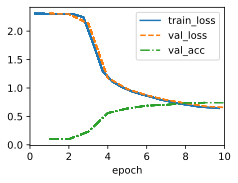

In [79]:
class LeNetMaxPooling(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
        
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNetMaxPooling()
model.layer_summary((1, 1, 28, 28))


trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNetMaxPooling(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

### ReLU

In [81]:
class LeNetMaxPoolingReLU(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.ReLU(),
            nn.LazyLinear(84), 
            nn.ReLU(),
            nn.LazyLinear(num_classes)) 
        
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNetMaxPoolingReLU()
model.layer_summary((1, 1, 28, 28))


trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNetMaxPoolingReLU(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

SyntaxError: invalid syntax (1452619038.py, line 3)

### Changing the Size of the Network

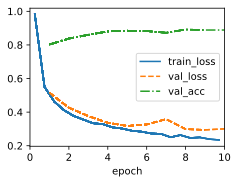

In [82]:
class ConvSize(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(30, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(20, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.ReLU(),
            nn.LazyLinear(84), 
            nn.ReLU(),
            nn.LazyLinear(num_classes)) 
    

@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = ConvSize()
model.layer_summary((1, 1, 28, 28))


trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = ConvSize(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

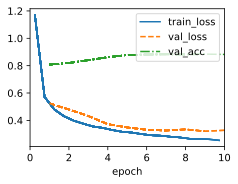

In [83]:
class OutSize(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=40):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.ReLU(),
            nn.LazyLinear(84), 
            nn.ReLU(),
            nn.LazyLinear(num_classes)) 
        
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)


trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = OutSize(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

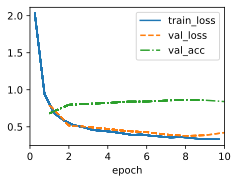

In [84]:
class ConvLayers(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=40):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), 
            nn.ReLU(),
            nn.LazyConv2d(20, kernel_size=5), 
            nn.ReLU(),
            nn.LazyConv2d(4, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.ReLU(),
            nn.LazyLinear(84), 
            nn.ReLU(),
            nn.LazyLinear(num_classes)) 
        
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)


trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = ConvLayers(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [89]:
class FullConnect(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.ReLU(),
            nn.LazyLinear(84), 
            nn.ReLU(),
            nn.LazyLinear(40),
            nn.ReLU(),
            nn.LazyLinear(28),
            nn.ReLU(),
            nn.LazyLinear(num_classes)) 
        
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)



trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = FullConnect(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [3]:
class FullNetwork(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.05, num_classes=8):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), 
            nn.ReLU(),
            nn.LazyConv2d(28, kernel_size=5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), 
            nn.ReLU(),
            nn.LazyLinear(84), 
            nn.ReLU(),
            nn.LazyLinear(40),
            nn.ReLU(),
            nn.LazyLinear(num_classes)) 
        
        
        
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)



trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = FullNetwork(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

c:\Users\aidan\PythonEnvironment\AI\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



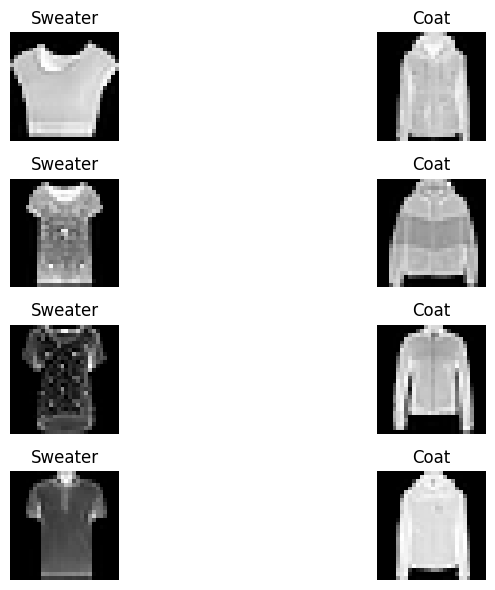

In [7]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Define a function to extract activations from the model
def get_activations(model, sample_images):
    activations = []
    for image in sample_images:
        # Pass the image through the model
        with torch.no_grad():
            output = model.net[:2](image.unsqueeze(0))  # Extract activations from the first two layers
        activations.append(output)
    return activations

# Load the FashionMNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Filter images of sweaters and coats
sweaters_indices = (dataset.targets == 0)  # Assuming class 0 represents sweaters
coats_indices = (dataset.targets == 4)     # Assuming class 4 represents coats

sweaters_loader = torch.utils.data.DataLoader(dataset, batch_size=4, sampler=torch.utils.data.SubsetRandomSampler(torch.where(sweaters_indices)[0]))
coats_loader = torch.utils.data.DataLoader(dataset, batch_size=4, sampler=torch.utils.data.SubsetRandomSampler(torch.where(coats_indices)[0]))

# Fetch a batch of sample images
sweaters_images, _ = next(iter(sweaters_loader))
coats_images, _ = next(iter(coats_loader))

# Create the model
model = FullNetwork(lr=0.1)

# Extract activations for sweaters and coats
sweaters_activations = get_activations(model, sweaters_images)
coats_activations = get_activations(model, coats_images)

# Plot activations
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(sweaters_images[i].squeeze(), cmap='gray')
    plt.title('Sweater')
    plt.axis('off')
    
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(coats_images[i].squeeze(), cmap='gray')
    plt.title('Coat')
    plt.axis('off')

plt.tight_layout()
plt.show()
